<a href="https://colab.research.google.com/github/manufabregas/Dataset-Asistencia-a-turnos-m-dicos/blob/main/TP%203/Grupo_2_TP_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
import pandas as pd
import numpy as np

# **1)Definir el problema de investigación a realizar. Si se trata de aprendizaje supervisado deberán elegir si lo abordarán como un problema de clasificación o regresión. Explicar qué motivación les llevó a elegir esta problemática en particular.**

---



**Problema**
El objetivo es predecir la asistencia de pacientes a sus citas médicas en un centro de salud, para optimizar la gestión del personal y recursos del centro. La clínica necesita saber cuántos pacientes asistirán cada día a fin de ajustar la cantidad de personal y recursos necesarios, evitando tanto la sobrecarga como la subutilización.


**Tipo de Aprendizaje:**
Este problema puede abordarse como un problema de clasificación supervisada. La variable objetivo (attendance) será binaria, donde:
* 1: si el paciente asiste a su cita
* 0: si no asiste.

**Motivación:**
Desde nuestro punto de vista, la clave del funcionamiento de un centro médico, radica en la calidad de los especialistas y el buen servicio. Una demora en la atención , puede significar una mala experiencia en el paciente, por lo que gestionar con eficiencia toda la cadena desde que empieza hasta que termina el día es crucial para el éxito.
Esto nos motiva a buscar la mejora continua en la gestión de hospitales, enfocándonos en optimizar la atención de turnos para lograr una mayor eficiencia en los costos y evitar la sobrecarga del personal.

In [13]:
df_base=pd.read_csv("./base_turnos_hospitales.csv")
df_base = df_base[['msp_name','doc_asistance_rate', 'msp_asistance_rate','dni_asistance_rate','age_avg','qt_canc_pac_ac', 'app_days_gap',"attendance"]]
df_base.head()

,msp_name,doc_asistance_rate,msp_asistance_rate,dni_asistance_rate,age_avg,qt_canc_pac_ac,app_days_gap,attendance
0,NEUROLOGIA,72.831978,71.085359,72.727273,77.0,2.0,39,0
1,CARDIOLOGIA INFANTIL,71.698113,75.919732,50.000000,7.0,0.0,48,0
2,NEUROLOGIA,72.831978,71.085359,37.500000,60.0,0.0,33,0
3,GINECOLOGIA Y OBSTETRICIA,89.130435,86.914721,50.000000,34.0,0.0,1,1
4,GINECOLOGIA,76.271186,71.529776,100.000000,60.0,0.0,13,1


In [14]:
#Recordamos la cantidad de filas y columnas
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43140 entries, 0 to 43139
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   msp_name            43140 non-null  object 
 1   doc_asistance_rate  43140 non-null  float64
 2   msp_asistance_rate  43140 non-null  float64
 3   dni_asistance_rate  43140 non-null  float64
 4   age_avg             43140 non-null  float64
 5   qt_canc_pac_ac      43140 non-null  float64
 6   app_days_gap        43140 non-null  int64  
 7   attendance          43140 non-null  int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 2.6+ MB


# **TRANSFORMAMOS LA COL MSP_NAME**

---



In [15]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Agrupamos por msp_name y contamos el total de attendance
df_total_attendance = df_base.groupby('msp_name')['attendance'].sum().reset_index()
df_total_attendance = df_total_attendance.sort_values(by='attendance')

# Agrupamos por msp_name y attendance, contamos las ocurrencias
df_attendance_bars = df_base.groupby(['msp_name', 'attendance']).size().reset_index(name='count')

# Creamos un subplot con un eje secundario
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Gráfico de líneas - Total de Attendance por Especialidad
fig.add_trace(
    go.Scatter(x=df_total_attendance['msp_name'], y=df_total_attendance['attendance'],
               name="Total Attendance", mode='lines+markers'),
    secondary_y=False
)

# Gráfico de barras - Attendance 0 y 1 por Especialidad
for attendance_val in [0, 1]:
    df_filtered = df_attendance_bars[df_attendance_bars['attendance'] == attendance_val]
    fig.add_trace(
        go.Bar(x=df_filtered['msp_name'], y=df_filtered['count'], name=f"Attendance {attendance_val}",
               opacity=0.6),
        secondary_y=True
    )

# Actualizamos los títulos y etiquetas
fig.update_layout(
    title="Total de Attendance por Especialidad (Línea) y Distribución por Attendance (Barras)",
    xaxis_title="Especialidad",
    yaxis_title="Total Attendance (Línea)",
    barmode='group',
    yaxis2_title="Cantidad de Attendance 0/1 (Barras)",
)

fig.update_layout(width=2000, height=800)


# Mostramos el gráfico
fig.show()


In [16]:
pip install category_encoders

# **TRANSFORMAMOS LA COL MSP_NAME PARA HACERLA NUMÉRICA**

---



In [17]:
import category_encoders as ce

encoder = ce.TargetEncoder(cols=['msp_name'])
df_base['msp_name_encoded'] = encoder.fit_transform(df_base['msp_name'], df_base['attendance'])
df_base.head(2)

,msp_name,doc_asistance_rate,msp_asistance_rate,dni_asistance_rate,age_avg,qt_canc_pac_ac,app_days_gap,attendance,msp_name_encoded
0,NEUROLOGIA,72.831978,71.085359,72.727273,77.0,2.0,39,0,0.681788
1,CARDIOLOGIA INFANTIL,71.698113,75.919732,50.000000,7.0,0.0,48,0,0.637736


**OTRA ALTERNATIVA DE ENCODING, PERO CON RESULTADOS SIMILARES:**

In [18]:
# import category_encoders as ce

# encoder = ce.CountEncoder(cols=['msp_name'])
# df_base['msp_name_encoded'] = encoder.fit_transform(df_base['msp_name'])
# df_base.head(2)

In [19]:
#Drop de la col msp_name que ya no nos hace falta
df_base=df_base.drop('msp_name',axis=1)
df_base.head(2)

,doc_asistance_rate,msp_asistance_rate,dni_asistance_rate,age_avg,qt_canc_pac_ac,app_days_gap,attendance,msp_name_encoded
0,72.831978,71.085359,72.727273,77.0,2.0,39,0,0.681788
1,71.698113,75.919732,50.000000,7.0,0.0,48,0,0.637736


In [20]:
#Separamos en X e Y
y = df_base.attendance
X = df_base.drop('attendance',axis=1)

# **ESTANDARIZAMOS LAS COLS**

---



In [21]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

x_names = X.columns  # Store column names
X_scaled = StandardScaler().fit_transform(X)  # Scale the data
X = pd.DataFrame(X_scaled, columns=x_names)  # Convert back to DataFrame with original column names

X

,doc_asistance_rate,msp_asistance_rate,dni_asistance_rate,age_avg,qt_canc_pac_ac,app_days_gap,msp_name_encoded
0,-0.378213,-0.805742,-0.026057,1.761069,0.319952,1.005551,-0.853879
1,-0.489198,-0.174922,-0.726693,-1.799023,-0.697647,1.502040,-1.588891
2,-0.378213,-0.805742,-1.112043,0.896475,-0.697647,0.674559,-0.853879
3,1.217113,1.259776,-0.726693,-0.425845,-0.697647,-1.090734,0.974982
4,-0.041576,-0.747752,0.814706,0.896475,-0.697647,-0.428749,-0.270524
...,...,...,...,...,...,...,...
43135,0.468418,0.264849,0.300906,-0.934429,-0.188848,-0.318418,0.974982
43136,0.104133,0.907742,-0.212894,0.387891,-0.188848,-0.263253,0.409426
43137,-1.158050,-1.617433,0.814706,0.591325,-0.697647,1.667536,-0.198899
43138,-0.063216,0.178018,-0.726693,-0.934429,-0.697647,-0.925238,-1.141052


In [22]:
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 8)

Decision Tree
Accuracy train Decision Tree: 0.9935%
Accuracy test Decision Tree: 0.8149%
Gradient Boosting
Accuracy train Gradient Boosting: 0.8644%
Accuracy test Gradient Boosting: 0.8682%
Random Forest
Accuracy train Random Forest: 0.9935%
Accuracy test Random Forest: 0.8457%


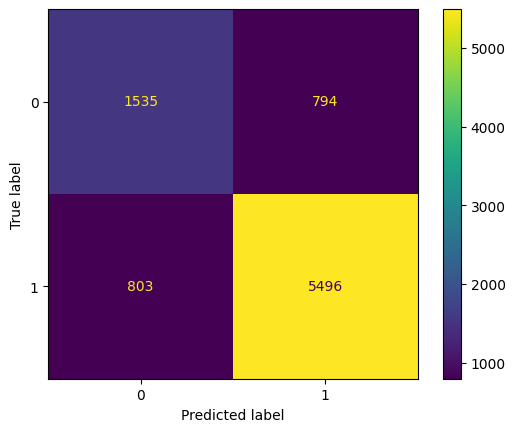

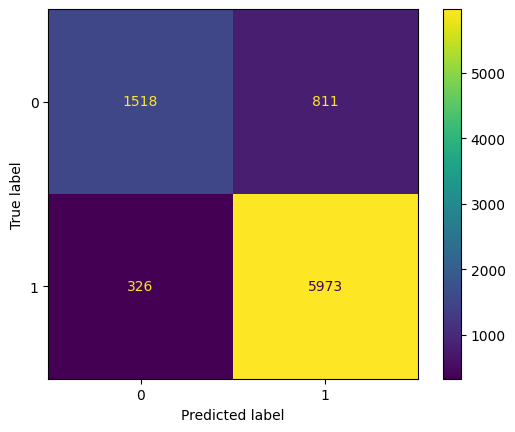

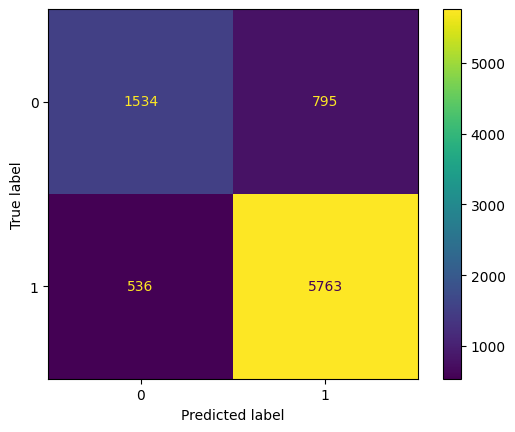

In [23]:
# from sklearn.metrics import accuracy_score

clfs = [
    DecisionTreeClassifier(),
    GradientBoostingClassifier(),
    RandomForestClassifier()
]

names = ['Decision Tree', 'Gradient Boosting', 'Random Forest']

trained_models = []
accuracy_models = []

for clf, name in zip(clfs, names):
    print(name)
    clf.fit(x_train, y_train)

    # Evaluate on training data
    train_predictions = clf.predict(x_train)
    train_accuracy = accuracy_score(y_train, train_predictions)
    print(f"Accuracy train {name}: {train_accuracy:.4f}%")

    # Evaluate on test data
    test_predictions = clf.predict(x_test)
    test_accuracy = accuracy_score(y_test, test_predictions)
    print(f"Accuracy test {name}: {test_accuracy:.4f}%")

    ConfusionMatrixDisplay.from_predictions(y_test, test_predictions)

    trained_models.append(clf)
    accuracy_models.append(test_accuracy * 100)

Se evaluarán los siguientes aspectos:
1- Que se apliquen los conceptos vistos con los profes en el teórico y en el práctico.

2- Que el entregable no sea solo la notebook. El informe debe tener un mensaje claro y debe presentarse en un formato legible para cualquier tipo de stakeholder. Además, se deberá entregar el dataset trabajado.

3- Capacidad de Análisis y justificación. Proactividad en la profundización de los análisis.

4- Criterio para elegir que solución aplicar en cada caso y con qué método implementarla.

5- Calidad y estilo de código.

Deadline tentativo para la entrega 16/09/2024

# Problemática 1:

En los **centros médicos**, la gestión de turnos se organiza según la agenda de cada especialista.

 Cada médico o médica alquila su consultorio en días y horarios específicos en el centro médico, y el **costo del espacio no varía** en función del número de pacientes atendidos.


  Esto significa que, desde un punto de vista económico, al centro médico no le afecta directamente si un paciente no asiste a su cita.
  
   Sin embargo, la clínica debe tener en cuenta la **cantidad de personal administrativo, de limpieza** y otros recursos necesarios para operar eficientemente.
   
   En días en los que las agendas de los especialistas están completamente llenas y todos los pacientes asisten, el personal del centro puede verse sobrecargado, lo que puede llevar a la necesidad de contratar personal adicional para manejar estas situaciones. Para optimizar la gestión del personal y los recursos, es crucial que las **clínicas puedan prever con antelación cuántos pacientes asistirán a los turnos médicos cada día.**

# **2)Seleccionar y preparar las variables que formarán parte de su modelo. Si consideran que hay otra variable a agregar y no fue construída con anterioridad lo pueden hacer. También variar en la naturaleza de las variables. Por ejemplo, si existe una variable que es continua (alguna tasa de asistencia o edad, etc) es aquí donde la pueden categorizar de la manera que consideren interesante abordar en el modelo.**

---



# **3)Construir el modelo. A continuación se dejan algunas observaciones:**

Seleccionar el algoritmo que consideren adecuado para el problema planteado y las variables elegidas.
Dividir el conjunto de datos en entrenamiento y prueba, y si lo consideran, en validación. Asegurar su replicabilidad.
Entrenamiento del modelo.
Optimización de hiperparámetros.
**En cada punto, justificar brevemente cada elección**

---



# **4)Evaluar el modelo.**
Evaluar el rendimiento del modelo a partir de métricas acordes a su problema de investigación. Interpretar.
Realizar validación cruzada.
Análizar y evaluar posibles mejoras del modelo frente a errores. (Explicar por qué se cree que tal algoritmo aplicado no dió los resultados deseados o esperados)
El punto 3 y 4 deberán aplicarse sobre dos algoritmos. La idea es que realicen la construcción y evaluación de dos modelos que consideren, para luego completar la próxima actividad.

---



# **5)Comparación de modelos. A partir de los dos modelos aplicados se deberá:**
Mencionar las principales caracteristicas (ventajas y desventajas generales) de cada algoritmo.
Fundamentar la elección de cada uno ante el problema de investigación planteado. ¿Por qué lo consideré en primer momento? ¿Por qué este algoritmo en primera instancia era el que mejores resultados podría arrojar para este conjunto de datos?
Comparar los resultados obtenidos con cada modelo a partir de las métricas, así como tiempos y costo computacional que insumieron.
Elegir un modelo final que sería presentado a sus clientes, fundamentando el por qué de su elección.
Si durante el desarrollo de este trabajo utilizan y/o aplican más de dos algoritmos pueden compartir la experiencia o resultados (teóricos) de por qué no fueron incluídos en el informe final. Se espera observar en la entrega solo los procedimientos de 2 de los modelos, nada más.

---

